## Dependencies

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open('data.txt', 'r').read().split()
len(words)

49061

In [3]:
words[:2]

['You', 'ever']

In [4]:
ctoi = {ch : i for i, ch in enumerate(sorted(set("".join(words))))}
itoc = {v:k for k, v in ctoi.items()}
Vocab_size = len(itoc)

### Data preprocess

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([194724, 3]) torch.Size([194724])
torch.Size([24510, 3]) torch.Size([24510])
torch.Size([24354, 3]) torch.Size([24354])


## Parameters random initialization 

In [6]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) 
B1 = torch.randn(n_hidden_1, generator=gen)
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen)
B2 = torch.randn((n_hidden_2), generator=gen)
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen)
B3 = torch.randn((Vocab_size), generator=gen)

parameters = [Cntx, W1, B1, W2, B2, W3, B3]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 90758


In [8]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) + B1
    
    # second layer
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 35.8265
  10000/ 200000: 2.0799
  20000/ 200000: 2.3376
  30000/ 200000: 2.1318
  40000/ 200000: 2.0884
  50000/ 200000: 1.8440
  60000/ 200000: 2.7863
  70000/ 200000: 2.1013
  80000/ 200000: 1.9978
  90000/ 200000: 1.7518
 100000/ 200000: 1.5079
 110000/ 200000: 1.9037
 120000/ 200000: 1.7396
 130000/ 200000: 2.0653
 140000/ 200000: 1.5651
 150000/ 200000: 1.6914
 160000/ 200000: 2.0533
 170000/ 200000: 1.3220
 180000/ 200000: 1.1270
 190000/ 200000: 2.0937


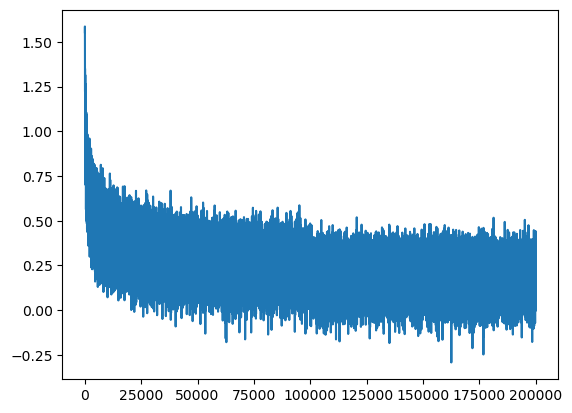

In [9]:
plt.plot(losses)

In [10]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1) + B1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.596331238746643
val 1.6905174255371094


#### Initially the logits are larger values so there gives false confident predictions during training. So we need to keep the logits values nearly zero then it will learn efficientsly. 

In [12]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) 
B1 = torch.randn(n_hidden_1, generator=gen)
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen)
B2 = torch.randn((n_hidden_2), generator=gen)
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen) * 0.01
B3 = torch.randn((Vocab_size), generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2, W3, B3]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 90758


#### So During initialization we need to scale down the weights at the same time bias are initializaed as zeros. Otherwise in the training process initially model squashes the weights and after thatit  starts to learn.

#### weights cannot to be initialized as zeros. 

In [13]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) + B1
    
    # second layer
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 4.3631
  10000/ 200000: 1.6277
  20000/ 200000: 1.2379
  30000/ 200000: 1.7699
  40000/ 200000: 1.5112
  50000/ 200000: 1.5030
  60000/ 200000: 1.9510
  70000/ 200000: 2.0139
  80000/ 200000: 1.5597
  90000/ 200000: 2.2384
 100000/ 200000: 1.3003
 110000/ 200000: 1.5999
 120000/ 200000: 1.3906
 130000/ 200000: 1.6202
 140000/ 200000: 2.1868
 150000/ 200000: 1.7466
 160000/ 200000: 1.5647
 170000/ 200000: 1.4853
 180000/ 200000: 1.8499
 190000/ 200000: 1.3395


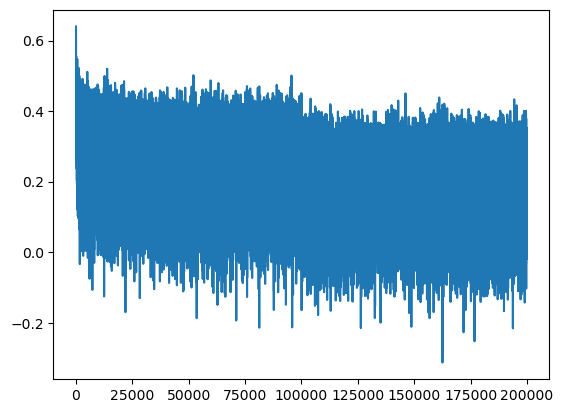

In [14]:
plt.plot(losses)

In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1) + B1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.5319740772247314
val 1.6005984544754028


(array([  1.,   2.,   3.,   1.,   5.,   5.,  15.,  16.,  10.,  21.,  44.,
         44.,  73.,  86.,  98., 188., 221., 230., 302., 308., 310., 405.,
        432., 372., 284., 430., 467., 343., 330., 279., 253., 214., 150.,
        122.,  82.,  88.,  64.,  32.,  25.,  22.,  11.,   2.,   3.,   2.,
          1.,   3.,   0.,   0.,   0.,   1.]),
 array([-30.27515984, -29.02558262, -27.7760054 , -26.52642818,
        -25.27685097, -24.02727375, -22.77769653, -21.52811932,
        -20.2785421 , -19.02896488, -17.77938766, -16.52981045,
        -15.28023323, -14.03065601, -12.7810788 , -11.53150158,
        -10.28192436,  -9.03234715,  -7.78276993,  -6.53319271,
         -5.28361549,  -4.03403828,  -2.78446106,  -1.53488384,
         -0.28530663,   0.96427059,   2.21384781,   3.46342503,
          4.71300224,   5.96257946,   7.21215668,   8.46173389,
          9.71131111,  10.96088833,  12.21046555,  13.46004276,
         14.70961998,  15.9591972 ,  17.20877441,  18.45835163,
         19.707928

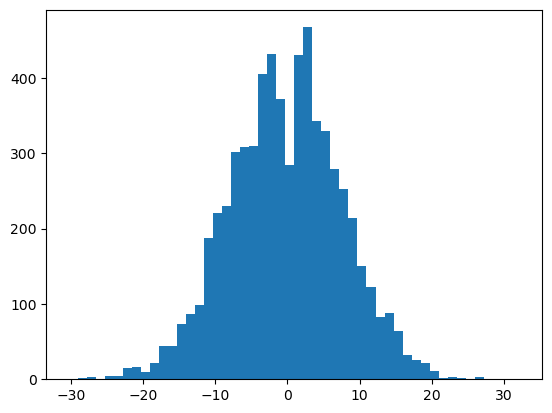

In [16]:
plt.hist(hpreact_1.view(-1).tolist(), 50)

(array([2.650e+03, 1.390e+02, 9.600e+01, 5.800e+01, 4.400e+01, 3.300e+01,
        1.600e+01, 1.800e+01, 2.100e+01, 1.700e+01, 9.000e+00, 1.500e+01,
        1.100e+01, 1.400e+01, 1.300e+01, 1.200e+01, 1.500e+01, 9.000e+00,
        7.000e+00, 1.300e+01, 6.000e+00, 8.000e+00, 5.000e+00, 8.000e+00,
        1.000e+00, 8.000e+00, 7.000e+00, 9.000e+00, 9.000e+00, 6.000e+00,
        9.000e+00, 9.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 1.100e+01,
        1.000e+01, 2.100e+01, 1.000e+01, 1.800e+01, 1.600e+01, 1.900e+01,
        3.800e+01, 2.700e+01, 3.100e+01, 4.300e+01, 5.700e+01, 7.300e+01,
        1.260e+02, 2.587e+03]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,

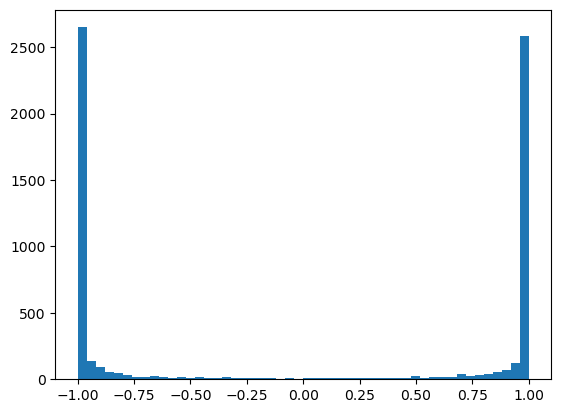

In [17]:
plt.hist(h_1.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   6.,   1.,   1.,   2.,  16.,   2.,  12.,  31.,
         27.,  33.,  60.,  84., 113., 157., 186., 258., 288., 342., 445.,
        476., 587., 610., 744., 391., 633., 644., 565., 521., 483., 392.,
        315., 290., 233., 178., 143.,  92.,  79.,  51.,  47.,  35.,   9.,
          9.,   3.,   3.,   0.,   1.,   1.]),
 array([-60.64214325, -58.37497261, -56.10780197, -53.84063133,
        -51.57346069, -49.30629005, -47.03911942, -44.77194878,
        -42.50477814, -40.2376075 , -37.97043686, -35.70326622,
        -33.43609558, -31.16892494, -28.9017543 , -26.63458366,
        -24.36741302, -22.10024239, -19.83307175, -17.56590111,
        -15.29873047, -13.03155983, -10.76438919,  -8.49721855,
         -6.23004791,  -3.96287727,  -1.69570663,   0.571464  ,
          2.83863464,   5.10580528,   7.37297592,   9.64014656,
         11.9073172 ,  14.17448784,  16.44165848,  18.70882912,
         20.97599976,  23.24317039,  25.51034103,  27.77751167,
         30.044682

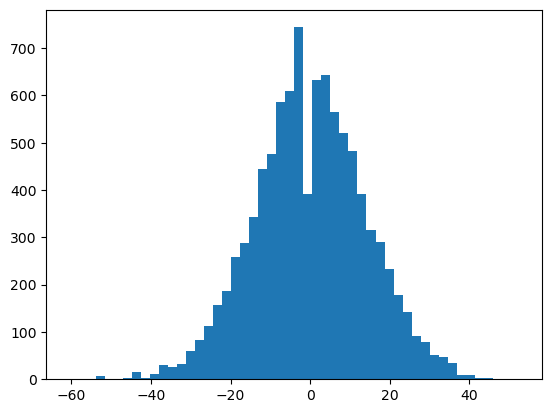

In [18]:
plt.hist(hpreact_2.view(-1).tolist(), 50)

(array([4.417e+03, 9.600e+01, 5.200e+01, 3.500e+01, 1.700e+01, 1.800e+01,
        1.600e+01, 1.100e+01, 1.200e+01, 9.000e+00, 1.000e+01, 1.200e+01,
        7.000e+00, 1.000e+01, 8.000e+00, 4.000e+00, 1.000e+01, 7.000e+00,
        7.000e+00, 9.000e+00, 1.100e+01, 6.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 8.000e+00, 4.000e+00, 5.000e+00, 9.000e+00,
        3.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 6.000e+00, 8.000e+00,
        7.000e+00, 1.100e+01, 1.300e+01, 9.000e+00, 1.400e+01, 1.600e+01,
        1.800e+01, 1.600e+01, 1.500e+01, 2.400e+01, 2.600e+01, 3.100e+01,
        1.180e+02, 4.427e+03]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,

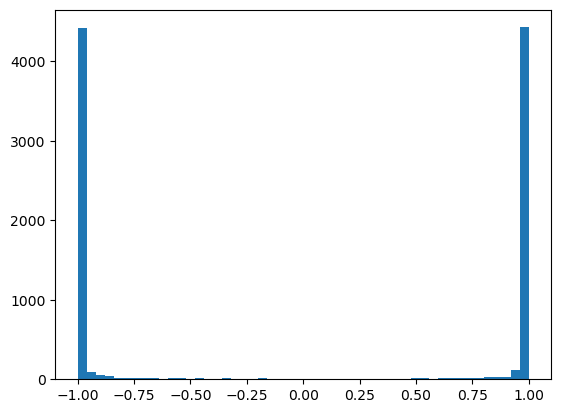

In [19]:
plt.hist(h_2.view(-1).tolist(), 50)

##### when the most of the hidden layer activation values are nearly equals to 1 or -1 the gradient values during the backpropagation will be nearly zeo. It's because the self.grad = (1-t**2)*out.grad

##### So the change in the input won't  impack the loss very much. This is a undesired condition in a  neural network

## properly initializing the hidden layer parameters 

In [20]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) * 0.02
B1 = torch.randn(n_hidden_1, generator=gen) * 0
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen) * 0.02
B2 = torch.randn((n_hidden_2), generator=gen)*0
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen) * 0.01
B3 = torch.randn((Vocab_size), generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2, W3, B3]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 90758


In [21]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) + B1
    
    # second layer
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 4.3566
  10000/ 200000: 1.6564
  20000/ 200000: 1.2655
  30000/ 200000: 1.5739
  40000/ 200000: 1.2684
  50000/ 200000: 1.3892
  60000/ 200000: 1.9049
  70000/ 200000: 1.7794
  80000/ 200000: 1.4941
  90000/ 200000: 2.1417
 100000/ 200000: 1.2701
 110000/ 200000: 1.5634
 120000/ 200000: 1.4038
 130000/ 200000: 1.6565
 140000/ 200000: 2.1467
 150000/ 200000: 1.7188
 160000/ 200000: 1.5495
 170000/ 200000: 1.4991
 180000/ 200000: 1.7687
 190000/ 200000: 1.3573


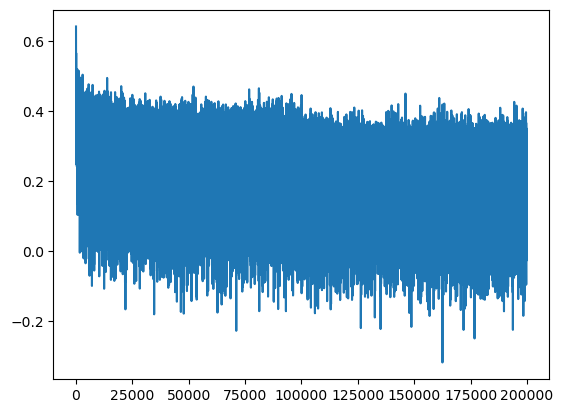

In [30]:
plt.plot(losses)

In [31]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1) + B1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 4.3577446937561035
val 4.357095718383789


(array([  5.,   3.,  10.,   4.,  11.,  13.,  21.,  35.,  43.,  32.,  53.,
        102.,  84., 113., 122., 155., 197., 250., 287., 292., 379., 391.,
        371., 359., 396., 396., 375., 324., 256., 229., 211., 187., 142.,
        146., 102.,  89.,  57.,  56.,  37.,  22.,  14.,   9.,   6.,   7.,
          1.,   3.,   0.,   0.,   0.,   3.]),
 array([-10.53846741, -10.09556797,  -9.65266853,  -9.2097691 ,
         -8.76686966,  -8.32397022,  -7.88107079,  -7.43817135,
         -6.99527191,  -6.55237247,  -6.10947304,  -5.6665736 ,
         -5.22367416,  -4.78077473,  -4.33787529,  -3.89497585,
         -3.45207642,  -3.00917698,  -2.56627754,  -2.12337811,
         -1.68047867,  -1.23757923,  -0.79467979,  -0.35178036,
          0.09111908,   0.53401852,   0.97691795,   1.41981739,
          1.86271683,   2.30561626,   2.7485157 ,   3.19141514,
          3.63431458,   4.07721401,   4.52011345,   4.96301289,
          5.40591232,   5.84881176,   6.2917112 ,   6.73461063,
          7.177510

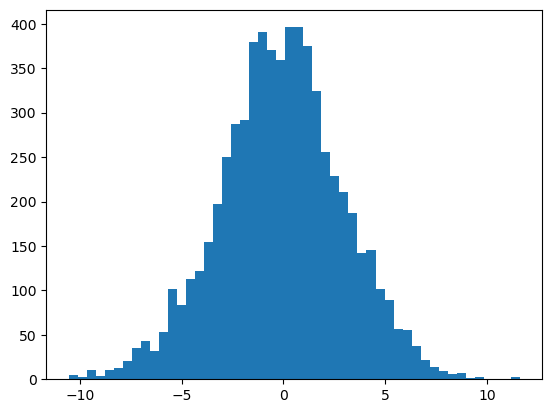

In [32]:
plt.hist(hpreact_1.view(-1).tolist(), 50)

(array([1652.,  246.,  169.,  175.,   95.,   80.,   98.,   54.,   49.,
          71.,   43.,   39.,   57.,   62.,   26.,   32.,   45.,   43.,
          29.,   34.,   21.,   26.,   47.,   38.,   22.,   43.,   33.,
          43.,   39.,   40.,   43.,   38.,   28.,   38.,   47.,   41.,
          35.,   34.,   40.,   66.,   82.,   71.,   57.,   68.,   93.,
         111.,  121.,  160.,  252., 1524.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

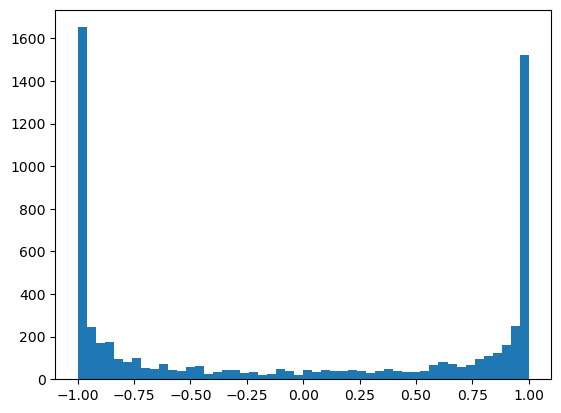

In [33]:
plt.hist(h_1.view(-1).tolist(), 50)

(array([   2.,    2.,    0.,    0.,    0.,    0.,    4.,   10.,    9.,
          11.,   24.,   39.,   46.,   51.,   56.,   90.,  107.,  148.,
         187.,  232.,  256.,  345.,  452.,  610.,  581.,  688., 1634.,
         693.,  598.,  664.,  529.,  334.,  253.,  214.,  140.,  150.,
         116.,   82.,   66.,   49.,   40.,   18.,   14.,   14.,    9.,
          12.,    7.,   10.,    2.,    2.]),
 array([-15.5797596 , -14.99096624, -14.40217289, -13.81337954,
        -13.22458618, -12.63579283, -12.04699947, -11.45820612,
        -10.86941277, -10.28061941,  -9.69182606,  -9.1030327 ,
         -8.51423935,  -7.925446  ,  -7.33665264,  -6.74785929,
         -6.15906593,  -5.57027258,  -4.98147923,  -4.39268587,
         -3.80389252,  -3.21509916,  -2.62630581,  -2.03751245,
         -1.4487191 ,  -0.85992575,  -0.27113239,   0.31766096,
          0.90645432,   1.49524767,   2.08404102,   2.67283438,
          3.26162773,   3.85042109,   4.43921444,   5.02800779,
          5.61680115,   

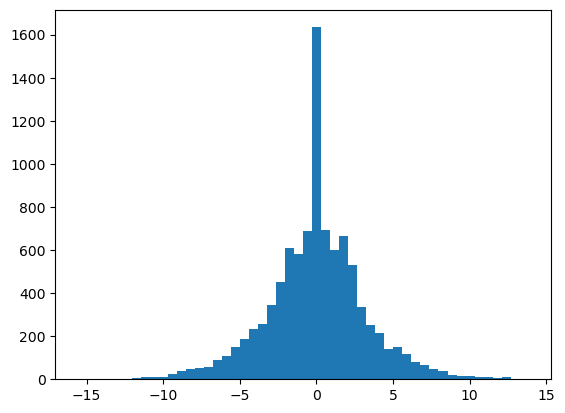

In [34]:
plt.hist(hpreact_2.view(-1).tolist(), 50)

(array([2164.,  395.,  184.,  134.,  123.,  117.,   79.,   94.,   84.,
          86.,   68.,   69.,   58.,   56.,   60.,   51.,   41.,   62.,
          71.,   69.,   74.,   83.,   88.,  174.,  212.,  289.,  138.,
         109.,   91.,   65.,   61.,   91.,   57.,   64.,   55.,   48.,
          61.,   70.,   81.,   69.,   66.,   77.,   89.,   95.,   98.,
         120.,  154.,  244.,  358., 2254.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

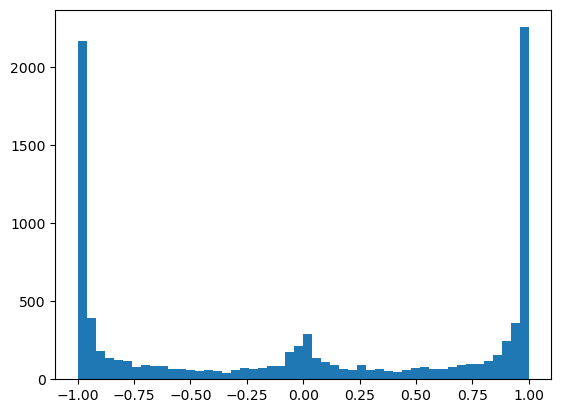

In [35]:
plt.hist(h_2.view(-1).tolist(), 50)

### Setting Initialization scales

##### because of tanh squashing the output values inbetween 1, -1 then this contracts the activation values. To reduce these contraction at the same time to boost these values we need to multiply py a gain value. Here it is 5/3

#### By this kaiming initialization we change the standard deviation of the weights

In [27]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
B1 = torch.randn(n_hidden_1, generator=gen) * 0.01
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen) * (5/3) / ((n_hidden_1)**0.5)
B2 = torch.randn((n_hidden_2), generator=gen) * 0.01
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen) * 0.01
B3 = torch.randn((Vocab_size), generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2, W3, B3]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 90758


In [28]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) + B1
    
    # second layer
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 4.3780
  10000/ 200000: 1.6345
  20000/ 200000: 1.2310
  30000/ 200000: 1.6192
  40000/ 200000: 1.2964
  50000/ 200000: 1.3410
  60000/ 200000: 1.9257
  70000/ 200000: 1.8269
  80000/ 200000: 1.6366
  90000/ 200000: 2.0702
 100000/ 200000: 1.2807
 110000/ 200000: 1.5675
 120000/ 200000: 1.4011
 130000/ 200000: 1.6261
 140000/ 200000: 2.1594
 150000/ 200000: 1.7542
 160000/ 200000: 1.5578
 170000/ 200000: 1.4991
 180000/ 200000: 1.8129
 190000/ 200000: 1.2400


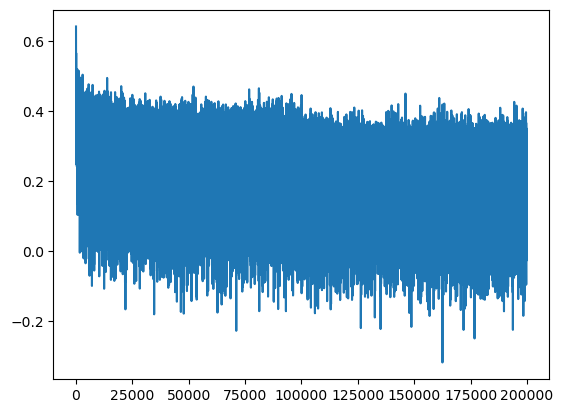

In [36]:
plt.plot(losses)

In [37]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1) + B1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 4.3577446937561035
val 4.357095718383789


#### If the hidden layer output values are too small numbers(pre-activation values) then the tanh here will be kind of inactive also if these are very large numbers then the tanh will be saturated then there is no learning. So we need to keep them roughly gaussion

## Batch normalization

#### we would like to initialize these valuese gaussion only during the initialization. After that it should follow it's own path.

##### To achieve that we are going to use gain and bias values. Initially gain is defined as all ones and bias will be defined as all zeros. So this will maintain the initial pre activation vallues to be unit gaussian. After that during training these values will be changed and the distribution can changed according to the learning so there won't be any blocker

In [40]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
B1 = torch.randn(n_hidden_1, generator=gen) * 0.01
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen) * (5/3) / ((n_hidden_1)**0.5)
B2 = torch.randn((n_hidden_2), generator=gen) * 0.01
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen) * 0.01
B3 = torch.randn((Vocab_size), generator=gen) * 0

bngain1, bnbias1 = torch.ones(1, n_hidden_1), torch.zeros(1, n_hidden_1)
bngain2, bnbias2 = torch.ones(1, n_hidden_2), torch.zeros(1, n_hidden_2)

bnmean_running1, bnstd_running1 = torch.zeros(1, n_hidden_1), torch.ones(1, n_hidden_1)
bnmean_running2, bnstd_running2 = torch.zeros(1, n_hidden_2), torch.ones(1, n_hidden_2)

parameters = [Cntx, W1, B1, W2, B2, W3, B3, bngain1, bnbias1, bngain2, bnbias2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 91758


In [41]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) + B1
    
    bnmean1i = hpreact_1.mean(0, keepdim=True)
    bnstd1i = hpreact_1.std(0, keepdim=True)
    
    # batch normalization
    hpreact_1 = bngain1 * (hpreact_1 - bnmean1i)/(bnstd1i) + bnbias1
    h_1 = torch.tanh(hpreact_1)
    
    # second layer
    hpreact_2 = (h_1 @ W2) + B2
    
    bnmean2i = hpreact_2.mean(0, keepdim=True)
    bnstd2i = hpreact_2.std(0, keepdim=True)
    
    # batch normalization
    hpreact_2 = bngain2 * (hpreact_2 - bnmean2i)/(bnstd2i) + bnbias2
    
    
    h_2 = torch.tanh(hpreact_2)
    
    with torch.no_grad():
        bnmean_running1 =(0.999 * bnmean_running1)  + (0.001 * bnmean1i)
        bnstd_running1 = (0.999 * bnstd_running1)  + (0.001 * bnstd1i)
        
        bnmean_running2 =(0.999 * bnmean_running2)  + (0.001 * bnmean2i)
        bnstd_running2 = (0.999 * bnstd_running2)  + (0.001 * bnstd2i)
        
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 4.3512
  10000/ 200000: 1.6953
  20000/ 200000: 1.2772
  30000/ 200000: 1.6475
  40000/ 200000: 1.5404
  50000/ 200000: 1.4788
  60000/ 200000: 1.8013
  70000/ 200000: 1.8747
  80000/ 200000: 1.6532
  90000/ 200000: 2.1340
 100000/ 200000: 1.2714
 110000/ 200000: 1.6164
 120000/ 200000: 1.4249
 130000/ 200000: 1.6969
 140000/ 200000: 2.2533
 150000/ 200000: 1.8407
 160000/ 200000: 1.5683
 170000/ 200000: 1.5780
 180000/ 200000: 1.9131
 190000/ 200000: 1.5548


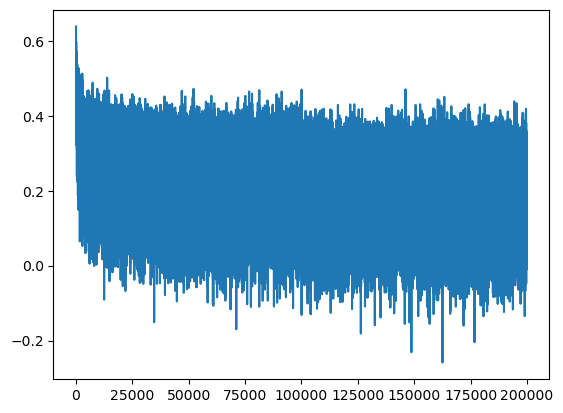

In [42]:
plt.plot(losses)

#### beacuse of the bnmean_running values are similar to bnmean values then the calibration after trainng is not necessary

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1) + B1
    hpreact_1 = bngain1 * (hpreact_1 - bnmean_running1)/bnstd_running1 + bnbias1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2) + B2
    hpreact_2 = bngain2 * (hpreact_2 - bnmean_running2)/bnstd_running2 + bnbias2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.5454806089401245
val 1.5902222394943237


### Because of the batch normalization has a bias(bnbias) parameter so the B1 is redundant

In [48]:
n_embd = 10
n_hidden_1 = 200
n_hidden_2 = 300

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
# B1 = torch.randn(n_hidden_1, generator=gen) * 0.01
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=gen) * (5/3) / ((n_hidden_1)**0.5)
# B2 = torch.randn((n_hidden_2), generator=gen) * 0.01
W3 = torch.randn((n_hidden_2, Vocab_size), generator=gen) * 0.01
B3 = torch.randn((Vocab_size), generator=gen) * 0

bngain1, bnbias1 = torch.ones(1, n_hidden_1), torch.zeros(1, n_hidden_1)
bngain2, bnbias2 = torch.ones(1, n_hidden_2), torch.zeros(1, n_hidden_2)

bnmean_running1, bnstd_running1 = torch.zeros(1, n_hidden_1), torch.ones(1, n_hidden_1)
bnmean_running2, bnstd_running2 = torch.zeros(1, n_hidden_2), torch.ones(1, n_hidden_2)

parameters = [Cntx, W1, W2, W3, B3, bngain1, bnbias1, bngain2, bnbias2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 91258


In [49]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    
    # first layer
    hpreact_1 = (embcat @ W1) 
    
    bnmean1i = hpreact_1.mean(0, keepdim=True)
    bnstd1i = hpreact_1.std(0, keepdim=True)
    
    # batch normalization
    hpreact_1 = bngain1 * (hpreact_1 - bnmean1i)/(bnstd1i) + bnbias1
    h_1 = torch.tanh(hpreact_1)
    
    # second layer
    hpreact_2 = (h_1 @ W2)
    
    bnmean2i = hpreact_2.mean(0, keepdim=True)
    bnstd2i = hpreact_2.std(0, keepdim=True)
    
    # batch normalization
    hpreact_2 = bngain2 * (hpreact_2 - bnmean2i)/(bnstd2i) + bnbias2
    
    
    h_2 = torch.tanh(hpreact_2)
    
    with torch.no_grad():
        bnmean_running1 =(0.999 * bnmean_running1)  + (0.001 * bnmean1i)
        bnstd_running1 = (0.999 * bnstd_running1)  + (0.001 * bnstd1i)
        
        bnmean_running2 =(0.999 * bnmean_running2)  + (0.001 * bnmean2i)
        bnstd_running2 = (0.999 * bnstd_running2)  + (0.001 * bnstd2i)
        
    
    # third layer
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())


      0/ 200000: 4.3215
  10000/ 200000: 1.6466
  20000/ 200000: 1.8438
  30000/ 200000: 1.0587
  40000/ 200000: 1.4242
  50000/ 200000: 1.3421
  60000/ 200000: 1.5758
  70000/ 200000: 1.3930
  80000/ 200000: 1.9678
  90000/ 200000: 1.2718
 100000/ 200000: 1.8252
 110000/ 200000: 1.5538
 120000/ 200000: 1.9477
 130000/ 200000: 1.7692
 140000/ 200000: 2.0537
 150000/ 200000: 1.6488
 160000/ 200000: 1.8469
 170000/ 200000: 1.4841
 180000/ 200000: 1.4895
 190000/ 200000: 1.5632


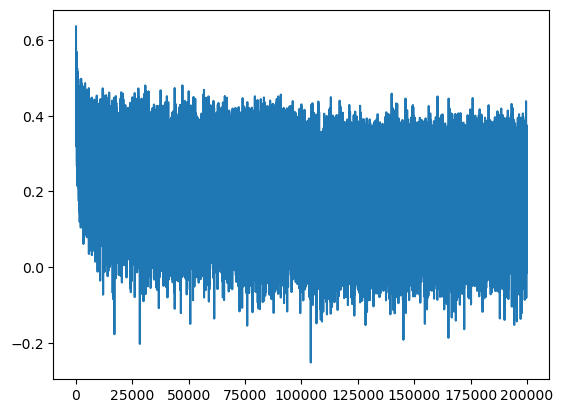

In [50]:
plt.plot(losses)

In [51]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact_1 = (embcat @ W1)
    hpreact_1 = bngain1 * (hpreact_1 - bnmean_running1)/bnstd_running1 + bnbias1
    
    h_1 = torch.tanh(hpreact_1)
    hpreact_2 = (h_1 @ W2)
    hpreact_2 = bngain2 * (hpreact_2 - bnmean_running2)/bnstd_running2 + bnbias2
    h_2 = torch.tanh(hpreact_2)
    
    logits = (h_2 @ W3) + B3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.5463429689407349
val 1.5907131433486938
